In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модели на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей 
    
    Отобразите на графике предсказание моделей и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

## Рассмотрим данные акций GOOG

In [88]:
df = pd.read_csv('data\\GOOG Historical Data.csv')

df

,Date,Open,High,Low,Close,Volume
0,2014-03-28,27.98,28.24,27.86,27.92,822312
1,2014-03-31,28.27,28.27,27.77,27.77,216032
2,2014-04-01,27.86,28.34,27.86,28.28,159076
3,2014-04-02,29.92,30.16,28.03,28.27,2941995
4,2014-04-03,28.41,29.28,28.13,28.41,102029960
...,...,...,...,...,...,...
2128,2022-09-08,109.00,110.57,108.08,109.42,21399424
2129,2022-09-09,110.00,111.98,110.00,111.78,21745034
2130,2022-09-12,111.99,112.64,110.94,111.87,19022568
2131,2022-09-13,108.75,109.30,105.02,105.31,32814424


## Добавим отдельный столбец, соответствующий действующей неделе и году в формате yyyy-ww
### ww - текущая неделя соответствующей даты

In [89]:
def fromDateToWeek(input_date):
    curr_iso = input_date.isocalendar()
    week_number = str(curr_iso[1]) if (len(str(curr_iso[1])) == 2) else ('0' + str(curr_iso[1]))
    return str(curr_iso[0]) + '-' + week_number


df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Week'] = df['Date'].map(fromDateToWeek)
df

,Date,Open,High,Low,Close,Volume,Week
0,2014-03-28,27.98,28.24,27.86,27.92,822312,2014-13
1,2014-03-31,28.27,28.27,27.77,27.77,216032,2014-14
2,2014-04-01,27.86,28.34,27.86,28.28,159076,2014-14
3,2014-04-02,29.92,30.16,28.03,28.27,2941995,2014-14
4,2014-04-03,28.41,29.28,28.13,28.41,102029960,2014-14
...,...,...,...,...,...,...,...
2128,2022-09-08,109.00,110.57,108.08,109.42,21399424,2022-36
2129,2022-09-09,110.00,111.98,110.00,111.78,21745034,2022-36
2130,2022-09-12,111.99,112.64,110.94,111.87,19022568,2022-37
2131,2022-09-13,108.75,109.30,105.02,105.31,32814424,2022-37


## Сгруппируем данные по неделям

In [90]:
from datetime import datetime


def fromWeekToDate(input_str_date):
    return datetime.strptime(input_str_date + '-0', "%Y-%W-%w")


print(df.groupby(df.Week))
dfm = df.groupby([df.Week]).mean()
dfm = dfm.rename_axis('Week').reset_index()
dfm['WeekDate'] = dfm['Week'].map(fromWeekToDate)
dfm['WeekDate'] = pd.to_datetime(dfm['WeekDate'])
dfm

,Week,Open,High,Low,Close,Volume,WeekDate
0,2014-13,27.9800,28.240000,27.860000,27.920000,8.223120e+05,2014-04-06
1,2014-14,28.6220,28.972000,27.774000,27.962000,4.665008e+07,2014-04-13
2,2014-15,27.3280,27.662000,26.808000,27.212000,7.544910e+07,2014-04-20
3,2014-16,27.0150,27.287500,26.417500,26.945000,9.070212e+07,2014-04-27
4,2014-17,26.4380,26.568000,26.096000,26.246000,4.392398e+07,2014-05-04
...,...,...,...,...,...,...,...
438,2022-33,121.1120,122.066000,120.106000,120.938000,1.689263e+07,2022-08-21
439,2022-34,115.1660,116.506000,113.804000,114.708000,1.926624e+07,2022-08-28
440,2022-35,110.7660,111.580000,108.808000,109.726000,2.187767e+07,2022-09-04
441,2022-36,108.7225,110.592500,108.087500,109.790000,2.157108e+07,2022-09-11


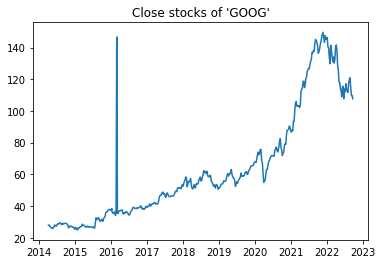

In [91]:
plt.title("Close stocks of 'GOOG'")
plt.plot(dfm.WeekDate, dfm.Close)
plt.show()

## Возьмем выборку данных из таблицы

In [92]:
def indexByPrediction(inputDf, prediction):
    return list(inputDf[inputDf.Week == prediction].index)[0]


start_week_value = '2020-01'
end_week_value = '2021-20'

start_week_index = indexByPrediction(dfm, start_week_value)
end_week_index = indexByPrediction(dfm, end_week_value)
dff = dfm[start_week_index:end_week_index].reset_index().drop('index', axis=1)
dff

,Week,Open,High,Low,Close,Volume,WeekDate
0,2020-01,67.1200,67.895,66.8775,67.5150,23037640.0,2020-01-12
1,2020-02,69.8820,70.736,69.5980,70.4160,32392996.0,2020-01-19
2,2020-03,72.1580,72.570,71.8380,72.4120,32266092.0,2020-01-26
3,2020-04,74.3925,74.825,73.7950,74.0475,33918120.0,2020-02-02
4,2020-05,72.4160,72.868,71.6540,72.3500,32671700.0,2020-02-09
...,...,...,...,...,...,...,...
67,2021-15,113.8280,114.436,112.9400,113.7120,24985296.0,2021-04-18
68,2021-16,114.6160,115.530,113.5280,114.7260,24039580.0,2021-04-25
69,2021-17,118.7800,119.948,117.9720,118.5400,38245916.0,2021-05-02
70,2021-18,118.9160,119.802,117.7980,118.8620,26921720.0,2021-05-09


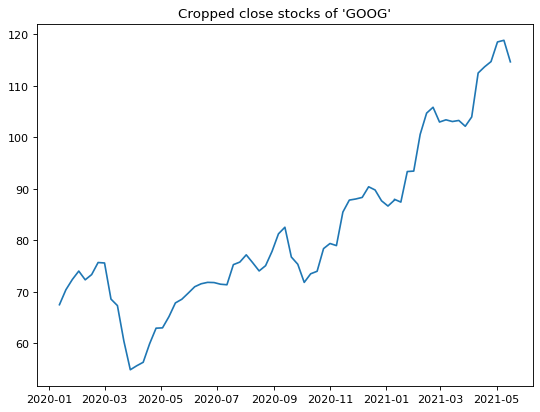

In [93]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Cropped close stocks of 'GOOG'")
plt.plot(dff.WeekDate, dff.Close)
plt.show()

<AxesSubplot:>

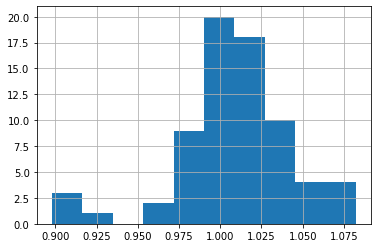

In [94]:
(dff['Close'] / dff['Close'].shift(1)).hist()

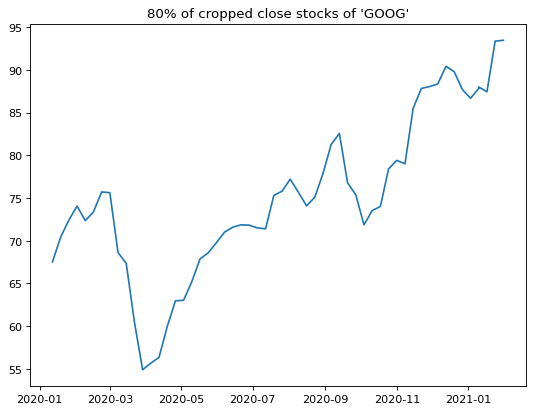

,Week,Open,High,Low,Close,Volume,WeekDate
0,2020-01,67.1200,67.8950,66.8775,67.5150,23037640.0,2020-01-12
1,2020-02,69.8820,70.7360,69.5980,70.4160,32392996.0,2020-01-19
2,2020-03,72.1580,72.5700,71.8380,72.4120,32266092.0,2020-01-26
3,2020-04,74.3925,74.8250,73.7950,74.0475,33918120.0,2020-02-02
4,2020-05,72.4160,72.8680,71.6540,72.3500,32671700.0,2020-02-09
5,2020-06,72.9900,73.9100,72.3180,73.3660,47303924.0,2020-02-16
6,2020-07,75.2880,76.0760,75.0020,75.7100,24238560.0,2020-02-23
7,2020-08,75.8750,76.3200,75.2650,75.6200,24496165.0,2020-03-01
8,2020-09,68.9500,70.0380,67.6100,68.6060,57273144.0,2020-03-08
9,2020-10,67.3740,68.5420,65.6800,67.3460,47876100.0,2020-03-15


In [108]:
df_l = dff[:int(dff.shape[0] * 0.8)] # 80% данных от выборки

plt.figure(figsize=(8, 6), dpi=80)
plt.title("80% of cropped close stocks of 'GOOG'")
plt.plot(df_l.WeekDate, df_l.Close)
plt.show()
df_l

## Сезонная декомпозиция

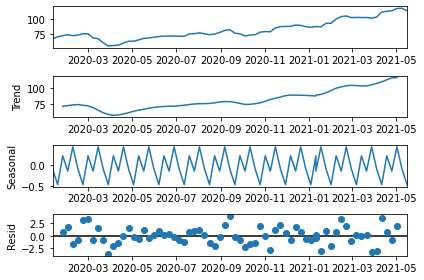

In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_sub_copy = pd.DataFrame.from_records(dff, columns=['Close', 'WeekDate'])
df_sub_copy = df_sub_copy.set_index('WeekDate')
df_sub_copy.sort_index(inplace=True)
df_sub_copy.index = pd.to_datetime(df_sub_copy.index)

result = seasonal_decompose(df_sub_copy, model='additive', period=7)
result.plot()

dfr = df_sub_copy


## Прохождение теста Дики — Фуллера

YES


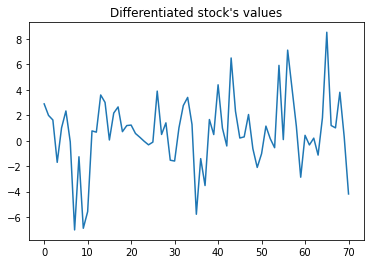

adf:  -6.124184605672426
p-value:  8.709090768058233e-08
Critical values:  {'1%': -3.5274258688046647, '5%': -2.903810816326531, '10%': -2.5893204081632653}


In [97]:
import statsmodels.tsa.api as smt

val_column = dfr.Close
upd_column = np.diff(val_column)

test = sm.tsa.adfuller(upd_column)

if test[0] > test[4]['5%']:
    print("NO")
else:
    print("YES")

plt.title("Differentiated stock's values")
plt.plot(upd_column)
plt.show()

print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])


In [98]:
## Задаем индексы, соответствующие 80% данных

In [99]:
proc_all = len(upd_column)
proc_max = int(len(upd_column) * 0.8)  # [0..proc_max]
proc_calculate = len(upd_column) - proc_max

In [100]:
## Функции дифференцирования

In [101]:
def regDiff(curr_data):
    return np.diff(curr_data)


def invRegDiff(curr_data, first_reg_elem):
    return np.hstack((first_reg_elem, curr_data)).cumsum()


In [102]:
## Auto Arima

In [103]:
from pmdarima.arima import auto_arima

model = auto_arima(regDiff(val_column[:proc_max]), start_p=0, start_q=0, d=1, D=1, test='adf', max_q=4, m=7,
                   start_P=0, seasonal=True, error_action='ignore', supress_warnings=False, trace=True, n_jobs=-1)

Performing stepwise search to minimize aic


C:\users\skat\appdata\local\programs\python\python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=269.658, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=251.581, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=263.487, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=250.184, Time=0.07 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=257.430, Time=0.04 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=250.515, Time=0.08 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=248.525, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=249.600, Time=0.04 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=246.127, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=244.136, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf

In [104]:
fitted = model.predict(n_periods=proc_calculate)

Ошибка:  0.04696936839521704


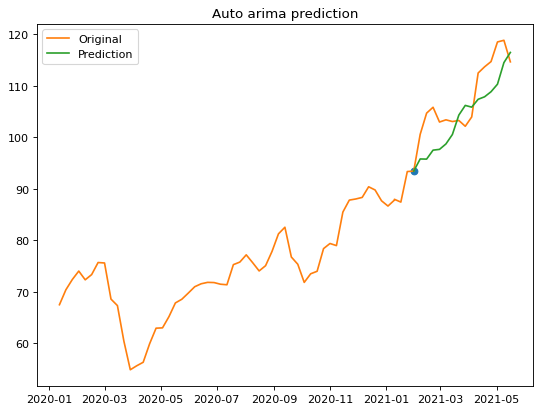

In [105]:
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

curr_index = dfr.index[proc_max]
idx = pd.date_range(dfr.index[proc_max], periods=proc_calculate + 1, freq='W')
arimaPrediction = pd.Series(invRegDiff(fitted, dfr.Close[proc_max]), index=idx)

plt.figure(figsize=(8, 6), dpi=80)
plt.title("Auto arima prediction")
plt.plot(dfr.index[proc_max], dfr.Close[proc_max], 'o')
plt.plot(dfr, label="Original")
plt.plot(arimaPrediction, label="Prediction")
plt.legend()

percentage_error = mean_absolute_percentage_error(arimaPrediction.tail(proc_calculate), dfr.tail(proc_calculate))
print("Ошибка: ", percentage_error)

Ошибка:  0.052019488072821


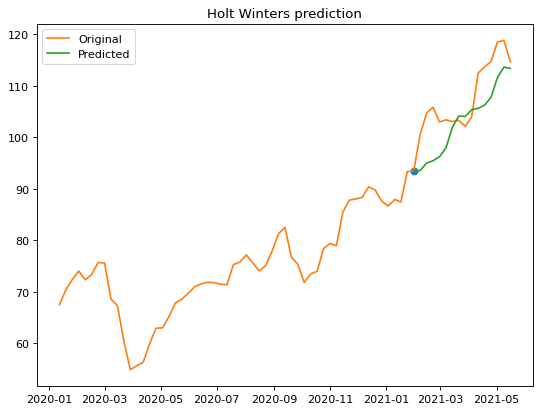

In [106]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

holtWinters = ExponentialSmoothing(
    regDiff(val_column[:proc_max]),
    seasonal_periods=7,
    trend="add",
    seasonal="add",
).fit()
fitted = holtWinters.predict(start=proc_max, end=proc_all - 1)
idx = pd.date_range(dfr.index[proc_max], periods=proc_calculate + 1, freq='W')
predictedSeries = pd.Series(invRegDiff(fitted, dfr.Close[proc_max]), index=idx)

plt.figure(figsize=(8, 6), dpi=80)
plt.title("Holt Winters prediction")
plt.plot(dfr.index[proc_max], dfr.Close[proc_max], 'o')
plt.plot(dfr, label="Original")
plt.plot(predictedSeries, label="Predicted")
plt.legend()

percentage_error = mean_absolute_percentage_error(predictedSeries.tail(proc_calculate), dfr.tail(proc_calculate))
print("Ошибка: ", percentage_error)

In [107]:
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
#
#temp2 = ExponentialSmoothing(
#    regDiff(val_column[:proc_max]),
#    seasonal_periods=7,
#    trend="add",
#    seasonal="add",
#).fit()
#fitted = temp2.predict(start=0, end=proc_all - 1)
#
#plt.plot(dfr)
#idx = pd.date_range(dfr.index[0], periods=proc_all + 1, freq='W')
#temp = pd.Series(invRegDiff(fitted, dfr.Close[0]), index=idx)
#plt.plot(temp)
#print(mean_absolute_percentage_error(temp, dfr))
#smt.graphics.plot_pacf(upd_column)